In [5]:
import sys

assert sys.version_info >= (3, 7)

In [6]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

AssertionError: 

In [7]:
#define the default font sizes to make the figures prettier:

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [8]:
# And let's create the images/classification folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [9]:
#fetch data from openml
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [10]:
# extra code – it's a bit too long
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [11]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
X.shape
#70000 total images and each image has 784 features as each image is 28*28 pixels. Each pixel represents one pixel's intensity from 0(white) to 255(black)

(70000, 784)

In [13]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [14]:
y.shape

(70000,)

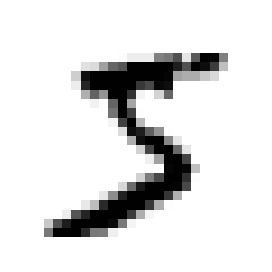

In [15]:
#look at one digit from dataset
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary") #binary gives grayscale colormap where 0 is white and 255 is black
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [16]:
y[0]

'5'

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
#Create test set and set it asside. Training set has first 60000 images and test set has last 10000 images

In [18]:
#Try to identify one digit for now
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [19]:
#Use SGDClassifier (Stochastic gradient descent) as it deals with training instances one at a time which makes it well suited for online learning
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
#Use it to detect images of number 5
sgd_clf.predict([some_digit])

array([ True])

In [21]:
# Measuring Accuracy Using Cross-Validation. 
from sklearn.model_selection import cross_val_score #k-fold cross validation with 3 folds. split training set into 3 folds and train the model 3 times

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#Above 95% accuracy on all cross-validation folds

array([0.95035, 0.96035, 0.9604 ])

In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [23]:
#Check the accuracy of non-5 images using dummyclassifier
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#Accuracy is not a preferred performance measure for classifiers, use confusion matrix instead

array([0.90965, 0.90965, 0.90965])

In [ ]:
#COnfusion matrix - count number of times instances of Class A classified as class B for all A/B pairs. e.g count number of times classifier confused images of 8 with 0
#for this we need set of actual predictions to compare with actual targets use cross_val_predict() function for this

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #makes predictions made on each test fold
y_train_pred

In [ ]:
#Use confusion matrix and pass it the target class (y_train_5) and prediction class (y_train_pred)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm
#each row represents an actual class while each column represents a predicted class
#first row considers non-5 images (negative class): 53892 correctly classified as non-5 (true negatives),687 wrongly classified as 5s (false positive, type 1 error)
#second row considers images of 5 (positive class): 1891 wrongly classified as non-5 (false negatives type II errors), 3530 correctly classified as 5s (true positive)
#Perfect classifier would only have true positives and true negatives

In [ ]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

In [ ]:
#Other way is to use precision and recall. precision = TP/(TP+FP) is used with recall (which is ratio of positive instances correctly detected by classifier) recall = TP/(TP+FN)
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)
#It is correct only 83.7% of time

In [ ]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)
#It only detects 65.1% of the 5s

In [ ]:
#F1-score = harmonic mean of precision and recall. Single metric to compare two classifiers
#F1 score = 2 * ((precision * recall)/(precision + recall))
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

In [ ]:
#precision-recall tradeoff: as precision increases recall decreases and vice versa
#we can have access to decision scores it uses to make predictions using decision_function() which returns score for each instance, then use any threshold to make predictions
y_scores = sgd_clf.decision_function([some_digit])
y_scores

In [ ]:
threshold = 0 #SGDClassifier uses threshold = 0, so this returns same result as predict()
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#raising threshold decreases recall. Image actually represents 5 and classifier detects it when threshold = 0. Fails to detect when threshold increased = 3000


In [ ]:
#use cross_val_predict() to get scores of all instances on training set and specify we want decision score
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

In [ ]:
#use precision_recall_curve() to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
#use matplotlib to plot precision and recall as functions of threshold value
plt.figure(figsize=(8, 4))  # formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

#  beautifies and saves Figure 
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")


In [ ]:
#can plot precision directly against recall
import matplotlib.patches as patches  # for the curved arrow

plt.figure(figsize=(6, 5))  #formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [ ]:
#suppose we aim for 90% precision, we can search for lowest threshold using numpy's argmax() that will give at least 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision
#returns first index of maximum value, first True Value

In [ ]:
#to make predictions (on training set for now), instead of calling predict() can use this
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
y_train_pred_90

In [ ]:
precision_score(y_train_5, y_train_pred_90)
#90% precision is good

In [ ]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision
#48% recall not at all good

In [ ]:
#ROC curve Receiver Operating Characteristic plots true positive rate (recall) against false positive rate (FPR also called fallout)
#Fallout = ratio of negative instances incorrectly classified as positive = 1- TNR. TNR true negative rate = ratio of negative instances correctly classified as negative
#TNR also called as specificity. ROC thus plots sensitivity(recall) versus 1-specificity
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
#FPR against TPR using matplotlib
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# beautifies and saves Figure
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [ ]:
#One way to compare classifiers is to measure area under the curve AUC. perfect classifier will have ROC AUC = 1
#purely random qualifier will have a ROC AUC = 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

In [ ]:
#Now let's create RandomForestClassifier and compare its PR curve snd F1 score with those of SDGClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
#Use predict_proba() that returns class probablities and use them as scores
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba") #use cross_val_predict()
y_probas_forest

In [ ]:
y_probas_forest[:2]
#predicts first image is positive with 89% probability and second image is negative with 99% probability
#probabilities in each row add up to 100%

In [ ]:
#These are estimated probabilities. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

In [ ]:
#second column contains estimated probabilities for positive class, let's pass them to precision_recall_curve() function
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

In [ ]:
#Plot PR curve
plt.figure(figsize=(6, 5))  # formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

#  beautifies and saves Figure
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

#random forest classifier is superior to SGD because it's PR curve is much closer to top-right corner and has greater AUC

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)
#f1 score better than SGD

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)
#auc better than SGD

In [ ]:
recall_score(y_train_5, y_train_pred_forest)
#recall score better

In [ ]:
precision_score(y_train_5, y_train_pred_forest)
#precision score better

In [ ]:
#Now let's try multiclass classification using binary classifier. 
#Scikit detects when we use binary classifier for multiclass and automatically runs OvR (one-vs-the-rest) or OvO (One-vs-One)
#Here we used support vector machine classifier
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5 and train only first 2000 images

#OvO strategy used and trained 45 classifiers = (10-1)*10/2

In [ ]:
#let's make prediction on image
svm_clf.predict([some_digit])
#this made 45 predictions and selected the class that won most duels

In [ ]:
#let's call decision_function() to check it returns 10 scores per instance per class. Score = number of duels won + or - small tweak (max +- 0.33)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

In [ ]:
#Highest score = 9.3 corresponding to digit 5. Let's check using argmax()
class_id = some_digit_scores.argmax()
class_id

In [ ]:
#After classifier is trained, target classes are stored in its classes_ attributes
svm_clf.classes_

In [ ]:
svm_clf.classes_[class_id]

In [ ]:
# shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

In [ ]:
#if we want to specifically use OvO or OvR,can use OneVsOneClassifier or OnevsRestClassifier, create an instance and pass a classifier to it's constructor
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

In [ ]:
#let's make prediction
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
#Training an SGDClassifier on multiclass dataset
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

#prediction error!

In [ ]:
#scikit used OvR strategy, since there are 10 classes, it trained 10 binary classifiers
#lets look at scores SGD Classifier assigned to each class using decision_function()

sgd_clf.decision_function([some_digit]).round()

#classifier not confident about its prediction as all scores are negative


In [ ]:
#cross_val_score() to evaluate the model
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

#85.8% accuracy on all folds

In [ ]:
#can increase the accuracy by scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
#Make predictions using cross_val_predict() and pass it through confusion matrix
#Let's look at the diagram to understand the errors better
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
#generates and saves Figure
#can use it to analyze prediction errors
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

In [ ]:
#Multilabel Classification
#used to output multiple classes for each instance (e.g face recognition)
#creates multilabel array containing 2 target labels for each digit
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7') # - first indicates whether digit is large (7,8,9)
y_train_odd = (y_train.astype('int8') % 2 == 1) #indicates whether its odd
y_multilabel = np.c_[y_train_large, y_train_odd] #creates multilabel array with these 2 target labels

knn_clf = KNeighborsClassifier() #creates KNeighborsClassifier() and trains model using multiple targets array
knn_clf.fit(X_train, y_multilabel)

In [ ]:
#make predictions
knn_clf.predict([some_digit])

#digit 5 is not large but is odd

In [ ]:
#to evaluate multilabel classifier, one way is to measure f1 score for each individual label and compute the avg score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

#for face recognition, we will need an weighted average, that is, to give each label (face) a weight equal to its support (number of instances with that target label)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

In [ ]:
#Multioutput Classification
#generalization pf multilabel classification where each label can be multiclass (can have more than 2 possible values)
#let's build a system that removes noise from image - returns clean image

#let's begin by creating training and test sets by taking MNIST images and adding noise to their pixel intensities with NumPy randint() function

np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
#  generates and saves Figure 
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

#noisy image on the left and clean image on the right

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()